# Preâmbulo

Imports, funções, downloads e instalação do Pytorch.

In [ ]:
 # Basic imports.
import os
import time
import numpy as np
import torch

from torch import nn
from torch import optim
from torch.nn import functional as F

from torch.utils.data import DataLoader
from torch.utils import data
from torch.backends import cudnn

from torchvision import models
from torchvision import datasets
from torchvision import transforms

from skimage import io

from sklearn import metrics

from matplotlib import pyplot as plt

%matplotlib inline

cudnn.benchmark = True

In [ ]:
# Setting predefined arguments.
args = {
    'epoch_num': 50,      # Number of epochs.
    'lr': 5e-4,           # Learning rate.
    'weight_decay': 1e-5, # L2 penalty.
    'num_workers': 3,     # Number of workers on data loader.
    'batch_size': 100,    # Mini-batch size.
    'print_freq': 1,      # Printing frequency.
    'lambda_var': 1.0,    # Variational multiplier in loss.
    'num_gauss': 40,      # Number of gaussians in bottleneck of VAE.
    'num_samples': 8,     # Number of samples to be generated in evaluation.
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


# Carregando o  MNIST

In [ ]:
# Root directory for the dataset (to be downloaded).
root = './'

# Transformations over the dataset.
data_transforms = transforms.Compose([
    transforms.ToTensor()
])

# Setting datasets and dataloaders.
train_set = datasets.MNIST(root,
                           train=True,
                           download=True,
                           transform=data_transforms)
test_set = datasets.MNIST(root,
                          train=False,
                          download=False,
                          transform=data_transforms)

# Setting dataloaders.
train_loader = DataLoader(train_set,
                          args['batch_size'],
                          num_workers=args['num_workers'],
                          shuffle=True)
test_loader = DataLoader(test_set,
                         args['batch_size'],
                         num_workers=args['num_workers'],
                         shuffle=False)

# Printing training and testing dataset sizes.
print('Size of training set: ' + str(len(train_set)) + ' samples')
print('Size of test set: ' + str(len(test_set)) + ' samples')

Size of training set: 60000 samples
Size of test set: 10000 samples


# AutoEncoder Variacional

Idealmente codificações compactas de dados redundantes (i.e. imagens) deveriam produzir representações latentes que fossem independentes uma da outra num nível semântico. Ou seja, cada bin num feature map latente $z$ de um autoencoder deveria codificar o máximo de informação possível (i.e. linhas verticais que compõem um '1', '7' ou '9'; ou círculos que compõem um '6', '8' ou '0') para a reconstrução dos dígitos do MNIST, por exemplo. A [inferência variacional](https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf) provém uma forma mais simples de computarmos o Maximum a Posteriori (MAP) de distribuições estatísticas complexas como as que estamos lidando.

![VAE Features](https://www.dropbox.com/s/fkvdn69tkh7tm1p/vae_gaussian.png?dl=1)

Se tivermos controle sobre representações latentes em $z$ que codificam features de algo nível semântico, podemos utilizar o Decoder de um AE para geração de novas amostras. Usando o Encoder de um AE tradicional, conseguimos partir do vetor de entrada $x$ e chegar no vetor latente $z \sim q(z ∣ x)$. Porém, como não temos controle sobre a distribuição $q$, não é possível fazer o caminho inverso, ou seja, a partir de $z$ modelar $x \sim p(x | z)$. Essa é a motivação para um Variational AutoEncoder (VAE).

![VAE x->z](https://www.dropbox.com/s/o8daaskdrhfav7r/VAE_Enc.png?dl=1)

![VAE z->x](https://www.dropbox.com/s/wqi8nsak84i11mi/VAE_Dec.png?dl=1)

Para podermos ter um controle maior sobre distribuição de cada bin de $z$, adicionamos uma "regularização" $\mathcal{L}_{KL}(\mu, \sigma)$ à loss de regressão $\mathcal{L}_{r}(x, \hat{x})$ de um AE tradicional. Percebe-se que $\mu$ e $\sigma$ devem codificar a média e o desvio padrão de distribuições gaussianas multivariadas, o que permite realizarmos uma amostragem dessa distribuição. Não podemos, porém, backpropagar de nós na nossa rede que realizem amostragem de uma distribuição. Portanto, precisamos do truque da reparametrização mostrado abaixo para backpropagarmos apenas por $\mu$ e $\sigma$, mas não por $\epsilon$.

![Reparametrization](https://jaan.io/images/reparametrization.png)

Assim, a arquitetura final de um VAE segue o esquema a seguir composto no bottleneck por um vetor $\mu$, um vetor $\sigma$ e um vetor $\epsilon$, que formam a representação latente $z = \mu + \sigma * \epsilon$.

![VAE training](https://www.dropbox.com/s/719vkfnfsobimmd/VAE_training.png?dl=1)

A ideia é que cada gaussiana codifique uma característica de alto nível nos dados, permitindo que utilizemos o modelo generativo do VAE para, de fato, gerar amostras novas verossímeis no domínio dos dados de treino.

![VAE gif](https://media.giphy.com/media/26ufgj5LH3YKO1Zlu/giphy.gif)

Para entender mais sobre "disentangled representations", ler o paper original do [VAE](https://arxiv.org/abs/1312.6114), o [$\beta$-VAE](https://openreview.net/references/pdf?id=Sy2fzU9gl) e o paper que propõe as [InfoGANs](https://arxiv.org/pdf/1606.03657.pdf):

# Atividade Prática: Implementando o VAE

1.   Defina a arquitetura do VAE. O Encoder da rede será composto de duas camadas precedendo as camadas $\mu$ e $\sigma$, de forma que $\mu$ e $\sigma$ recebam as mesmas entradas e se combinem como explicado a cima para formar o vetor latente $z$. A dimensionalidade de entrada dos dados ($784$) deve ser diminuída gradativamente até chegar no bottleneck, assim como nosso primeiro exemplo do AE Linear. Ambas camadas $\mu$ e $\sigma$ devem receber dados de dimensionalidade alta e codificá-los para uma saída dada pela variável *n_gaus*. Não é preciso criar uma camada explícita para $\epsilon$, já que ele só representa a amostragem de uma distribuição gaussiana ([torch.randn()](https://pytorch.org/docs/stable/torch.html#torch.randn));
2.   Complete a implementação dos métodos *encode()* que encapsula o forward pelo Encoder, *reparameterize()* que amostra $\epsilon$ e realiza o truque da reparametrização e *decode()* que faz o forward de $z$ pelo Decoder da rede, o qual deve ser simétrico ao encoder, ou seja, receber *n_gaus* features vindos de $z$ e gradativamente aumentar os features para recuperar $784$ features. Dica: na função *reparameterize()*;
3.   Defina a loss composta do VAE na função *variational_loss()*. Essa função deve retornar o componente $\mathcal{L}_{r}$ da loss (já feito usando a BCE) e o componente $\mathcal{L}_{KL}$. Dica: ver o Apêndice B do paper dos [VAEs](https://arxiv.org/pdf/1312.6114.pdf) para a fórmula de $\mathcal{L}_{KL}$;
4.   Na função *generate_2d()* altere as dimensões da tupla *dim_linspace* até achar um par de dimensões que influencie os novos samples em alto nível semântico.

# Definindo a arquitetura

In [ ]:
# AutoEncoder implementation.
class VariationalAutoEncoder(nn.Module):
    
    def __init__(self, n_gaus):

        super(VariationalAutoEncoder, self).__init__()
        
        self.n_gaus = n_gaus
        
        # TO DO: Encoder.
        self.enc_1 = nn.Linear(784, 256)
        self.enc_2 = nn.Linear(256, 128)
        
        # TO DO: Layers mu and sigma.
        self.enc_mu = nn.Linear(128, 40)
        self.enc_sigma = nn.Linear(128, 40)
        
        # TO DO: Decoder.
        self.dec_1 = nn.Linear(40, 128)
        self.dec_2 = nn.Linear(128, 256)
        self.dec_3 = nn.Linear(256, 784)
        
        self.initialize_weights()
        
    # TO DO: Encoding function.
    def encode(self, x):
        x = F.relu(self.enc_1(x))
        x = F.relu(self.enc_2(x))
        return self.enc_mu(x), self.enc_sigma(x)
        
    # TO DO: Decoding function.
    def decode(self, z):
        z = F.relu(self.dec_1(z))
        z = F.relu(self.dec_2(z))
        return torch.sigmoid(self.dec_3(z))
               
    # TO DO: Reparametrization function. 
    def reparameterize(self, mu, logvar):
        
        std = torch.exp(0.5 * logvar)
        
        # TO DO: sample eps from gaussian.
        eps = torch.randn_like(std)
        
        # TO DO: compute z using mu, eps and std.
        z = mu + eps*std
        
        return z
    
    # Function for randomly initializing weights.
    def initialize_weights(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        
        # TO DO: Call method encode().
        mu, logvar = self.encode(x.view(-1, 784))
        
        # TO DO: Use mu and logvar to compute z in method reparameterize().
        z = self.reparameterize(mu, logvar)
        
        # TO DO: Call method decode().
        dec = self.decode(z)
        
        return dec, mu, logvar

# Instantiating architecture.
net = VariationalAutoEncoder(args['num_gauss']).to(args['device'])

# Printing architecture.
print(net)

VariationalAutoEncoder(
  (enc_1): Linear(in_features=784, out_features=256, bias=True)
  (enc_2): Linear(in_features=256, out_features=128, bias=True)
  (enc_mu): Linear(in_features=128, out_features=40, bias=True)
  (enc_sigma): Linear(in_features=128, out_features=40, bias=True)
  (dec_1): Linear(in_features=40, out_features=128, bias=True)
  (dec_2): Linear(in_features=128, out_features=256, bias=True)
  (dec_3): Linear(in_features=256, out_features=784, bias=True)
)


# Definindo o otimizador

In [ ]:
optimizer = optim.Adam(net.parameters(),
                       lr=args['lr'],
                       weight_decay=args['weight_decay'])

# Definindo a loss

In [ ]:
# TO DO: Reconstruction + KL losses summed over all elements and batch.
def variational_loss(recon_x, x, mu, logvar):
    
    # Reconstruction loss using BCE.
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # TO DO: KL Divergence loss.
    # See Appendix B from VAE paper:
    #     https://arxiv.org/pdf/1312.6114.pdf.
    # See Pytorch's implementation of VAEs:
    #     https://github.com/pytorch/examples/blob/master/vae/main.py.
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE, KLD

# Criando funções para Treino e Teste

In [ ]:
# Training procedure.
def train(train_loader, net, optimizer, epoch):

    tic = time.time()
    
    # Setting network for training mode.
    net.train()

    # Lists for losses and metrics.
    train_loss = []
    
    # Iterating over batches.
    for i, batch_data in enumerate(train_loader):

        # Obtaining images and labels for batch.
        inps, labs = batch_data
        
        # Casting to cuda variables and reshaping.
        inps = inps.view(inps.size(0), -1).to(args['device'])
        
        # Clears the gradients of optimizer.
        optimizer.zero_grad()

        # Forwarding.
        outs, mu, logvar = net(inps)

        # TO DO Computing total loss.
        loss_bce, loss_kld = variational_loss(outs, inps, mu, logvar)
        loss = loss_bce + loss_kld

        # Computing backpropagation.
        loss.backward()
        optimizer.step()
        
        # Updating lists.
        train_loss.append((loss_bce.data.item(),
                           args['lambda_var'] * loss_kld.data.item(),
                           loss.data.item()))
    
    toc = time.time()
    
    train_loss = np.asarray(train_loss)
    
    # Printing training epoch loss and metrics.
    print('-------------------------------------------------------------------')
    print('[epoch %d], [train bce loss %.4f +/- %.4f], [train kld loss %.4f +/- %.4f], [training time %.2f]' % (
        epoch, train_loss[:,0].mean(), train_loss[:,0].std(), train_loss[:,1].mean(), train_loss[:,1].std(), (toc - tic)))
    print('-------------------------------------------------------------------')
    

In [ ]:
# Testing procedure.
def test(test_loader, net, epoch):

    tic = time.time()
    
    # Setting network for evaluation mode.
    net.eval()

    # Lists for losses and metrics.
    test_loss = []
    
    # Iterating over batches.
    for i, batch_data in enumerate(test_loader):

        # Obtaining images and labels for batch.
        inps, labs = batch_data

        # Casting to cuda variables and reshaping.
        inps = inps.view(inps.size(0), -1).to(args['device'])

        # Forwarding.
        outs, mu, logvar = net(inps)

        # Computing loss.
        loss_bce, loss_kld = variational_loss(outs, inps, mu, logvar)
        loss = loss_bce + loss_kld
        
        # Updating lists.
        test_loss.append((loss_bce.data.item(),
                          args['lambda_var'] * loss_kld.data.item(),
                          loss.data.item()))
        
        if i == 0 and epoch % args['print_freq'] == 0:
            
            fig, ax = plt.subplots(2, 8, figsize=(16, 4))
        
        if i < 8 and epoch % args['print_freq'] == 0:
            
            ax[0, i].imshow(inps.view(inps.size(0), 28, 28)[0].detach().cpu().numpy())
            ax[0, i].set_yticks([])
            ax[0, i].set_xticks([])
            ax[0, i].set_title('Image ' + str(i + 1))
            
            ax[1, i].imshow(outs.view(inps.size(0), 28, 28)[0].detach().cpu().numpy())
            ax[1, i].set_yticks([])
            ax[1, i].set_xticks([])
            ax[1, i].set_title('Reconstructed ' + str(i + 1))
            
        if i == 8 and epoch % args['print_freq'] == 0:
            
            plt.show()
    
    toc = time.time()
    
    test_loss = np.asarray(test_loss)
    
    # Printing training epoch loss and metrics.
    print('-------------------------------------------------------------------')
    print('[epoch %d], [test bce loss %.4f +/- %.4f], [test kld loss %.4f +/- %.4f], [testing time %.2f]' % (
        epoch, test_loss[:,0].mean(), test_loss[:,0].std(), test_loss[:,1].mean(), test_loss[:,1].std(), (toc - tic)))
    print('-------------------------------------------------------------------')

In [ ]:
# Evaluation procedure for sample generation.
def evaluate(net, n_samples, n_gauss):

    # Setting network for evaluation mode.
    net.eval()
    
    # Plotting new samples generated from VAE.
    fig, ax = plt.subplots(1, n_samples, figsize=(n_samples*2, 2))

    # Iterating over batches.
    for i in range(n_samples):
        
        # Sampling from Gaussian.
        sample = torch.randn(1, n_gauss).to(args['device'])
        
        # Forwarding through Decoder.
        sample = net.decode(sample).detach().cpu().view(28, 28).numpy()
        
        ax[i].imshow(sample)
        ax[i].set_yticks([])
        ax[i].set_xticks([])
        ax[i].set_title('New Sample ' + str(i + 1))
        
    plt.show()

# Iterando sobre epochs

-------------------------------------------------------------------
[epoch 1], [train bce loss 21636.8934 +/- 6404.6246], [train kld loss 382.0055 +/- 479.4999], [training time 10.51]
-------------------------------------------------------------------


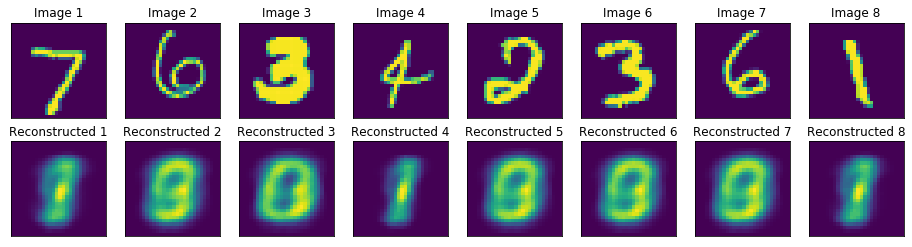

-------------------------------------------------------------------
[epoch 1], [test bce loss 19240.1460 +/- 1049.7801], [test kld loss 267.1875 +/- 58.1049], [testing time 2.23]
-------------------------------------------------------------------


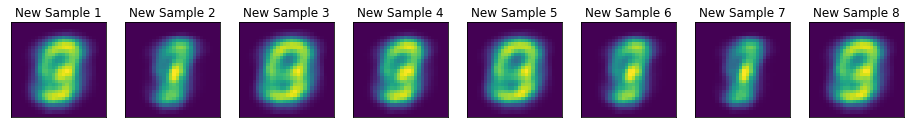

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 2], [train bce loss 18939.0648 +/- 580.5265], [train kld loss 323.1457 +/- 72.9024], [training time 10.74]
-------------------------------------------------------------------


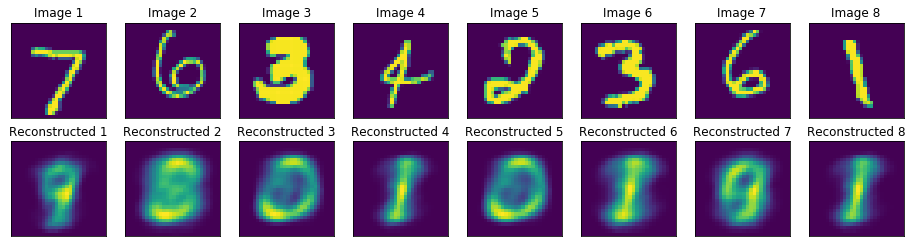

-------------------------------------------------------------------
[epoch 2], [test bce loss 17897.5789 +/- 1011.7224], [test kld loss 490.6502 +/- 79.6209], [testing time 2.09]
-------------------------------------------------------------------


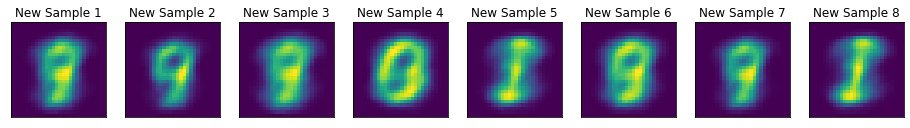

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 3], [train bce loss 17055.5568 +/- 704.4018], [train kld loss 559.7476 +/- 59.9124], [training time 10.63]
-------------------------------------------------------------------


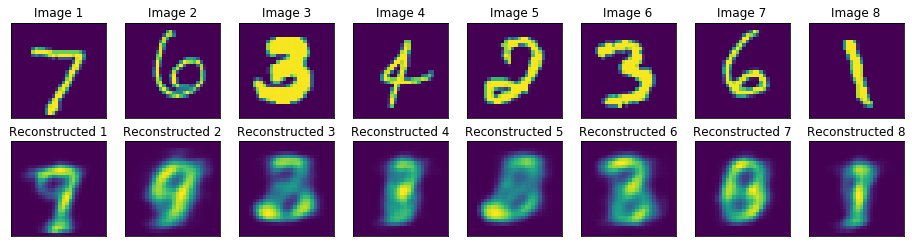

-------------------------------------------------------------------
[epoch 3], [test bce loss 16086.8361 +/- 786.7769], [test kld loss 670.0547 +/- 86.8446], [testing time 2.26]
-------------------------------------------------------------------


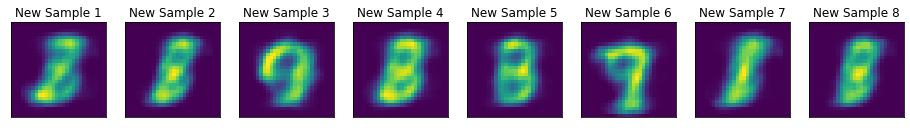

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 4], [train bce loss 15285.2105 +/- 667.8573], [train kld loss 772.3555 +/- 51.5465], [training time 10.78]
-------------------------------------------------------------------


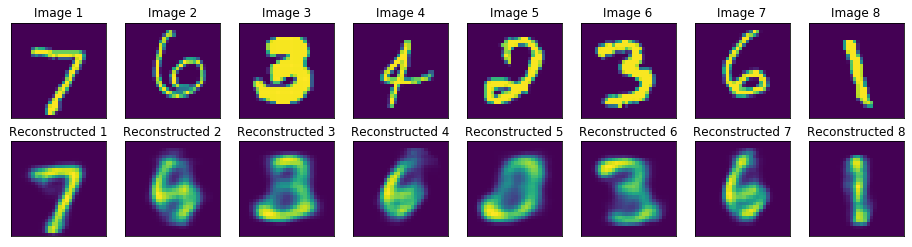

-------------------------------------------------------------------
[epoch 4], [test bce loss 14489.0689 +/- 697.3071], [test kld loss 838.7576 +/- 86.7216], [testing time 2.14]
-------------------------------------------------------------------


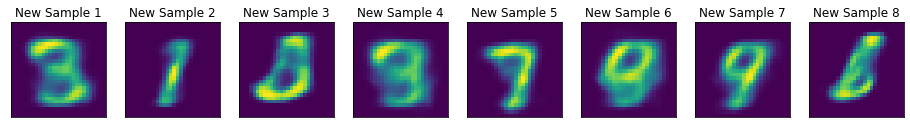

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 5], [train bce loss 13747.2340 +/- 616.3326], [train kld loss 927.3115 +/- 63.2288], [training time 10.87]
-------------------------------------------------------------------


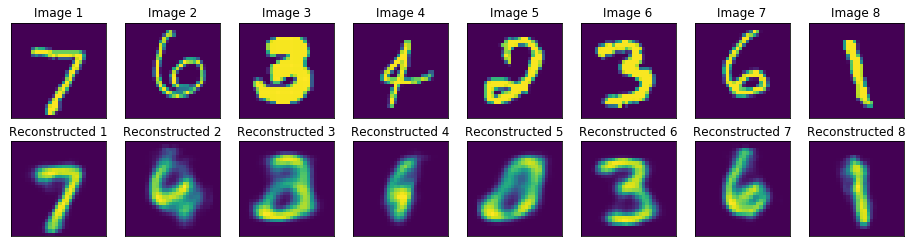

-------------------------------------------------------------------
[epoch 5], [test bce loss 13101.4818 +/- 664.8497], [test kld loss 993.8291 +/- 84.3211], [testing time 2.30]
-------------------------------------------------------------------


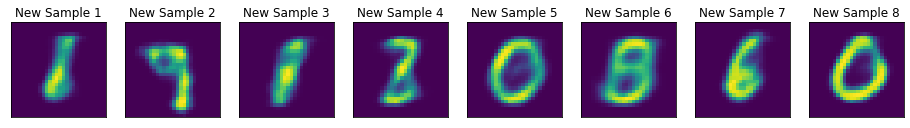

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 6], [train bce loss 12827.8425 +/- 485.1974], [train kld loss 1020.6267 +/- 41.4638], [training time 10.75]
-------------------------------------------------------------------


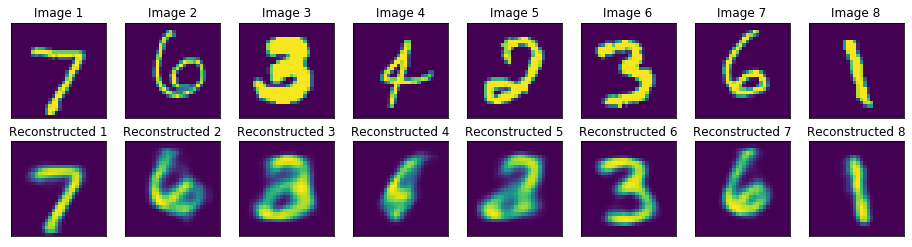

-------------------------------------------------------------------
[epoch 6], [test bce loss 12314.9294 +/- 603.1818], [test kld loss 1104.9516 +/- 93.6218], [testing time 2.13]
-------------------------------------------------------------------


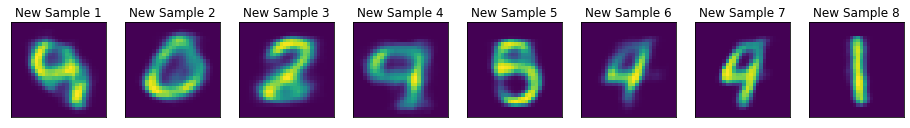

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 7], [train bce loss 12062.3911 +/- 433.2848], [train kld loss 1148.4120 +/- 33.8992], [training time 10.83]
-------------------------------------------------------------------


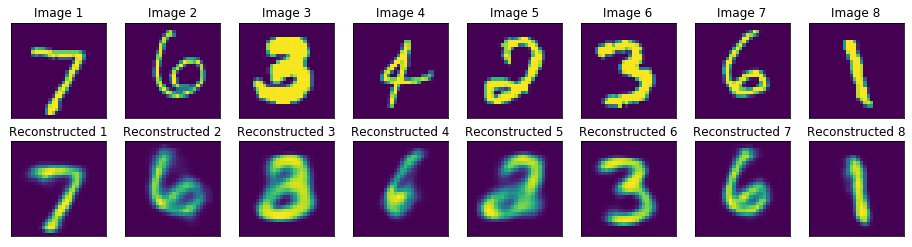

-------------------------------------------------------------------
[epoch 7], [test bce loss 11713.8075 +/- 572.3488], [test kld loss 1177.6534 +/- 70.7211], [testing time 2.28]
-------------------------------------------------------------------


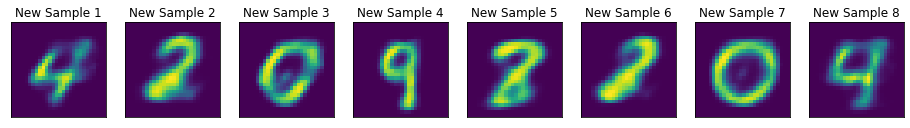

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 8], [train bce loss 11640.7221 +/- 405.3694], [train kld loss 1183.2496 +/- 24.4903], [training time 10.82]
-------------------------------------------------------------------


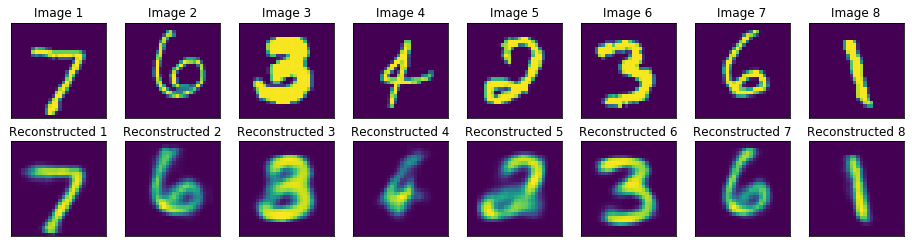

-------------------------------------------------------------------
[epoch 8], [test bce loss 11461.9387 +/- 563.8627], [test kld loss 1170.0229 +/- 56.8065], [testing time 2.17]
-------------------------------------------------------------------


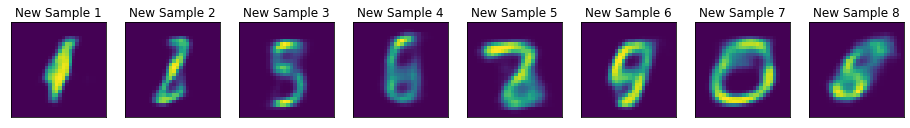

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 9], [train bce loss 11408.6691 +/- 422.5463], [train kld loss 1197.9114 +/- 21.9965], [training time 10.74]
-------------------------------------------------------------------


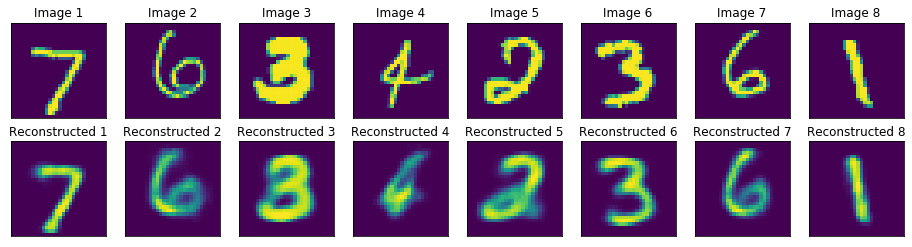

-------------------------------------------------------------------
[epoch 9], [test bce loss 11271.2223 +/- 570.1310], [test kld loss 1187.7890 +/- 57.4401], [testing time 2.12]
-------------------------------------------------------------------


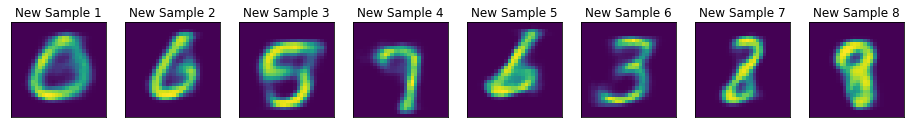

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 10], [train bce loss 11237.1040 +/- 412.9279], [train kld loss 1214.3239 +/- 23.2801], [training time 10.77]
-------------------------------------------------------------------


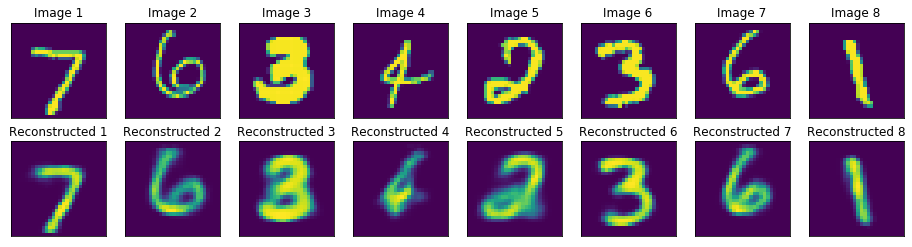

-------------------------------------------------------------------
[epoch 10], [test bce loss 11106.7774 +/- 567.9444], [test kld loss 1230.2012 +/- 53.2341], [testing time 2.19]
-------------------------------------------------------------------


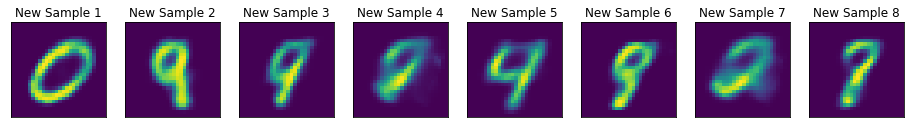

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 11], [train bce loss 11098.7549 +/- 365.9210], [train kld loss 1228.4326 +/- 21.4934], [training time 10.84]
-------------------------------------------------------------------


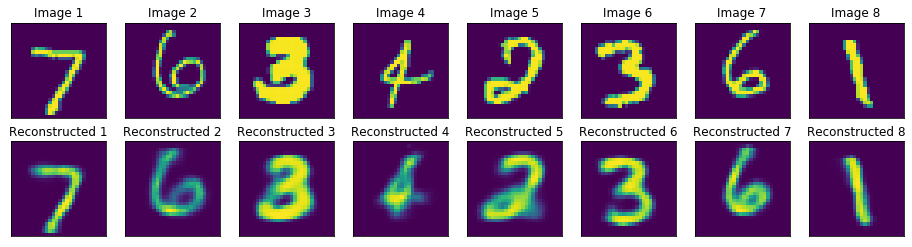

-------------------------------------------------------------------
[epoch 11], [test bce loss 10981.6039 +/- 569.1069], [test kld loss 1239.5916 +/- 54.2500], [testing time 2.17]
-------------------------------------------------------------------


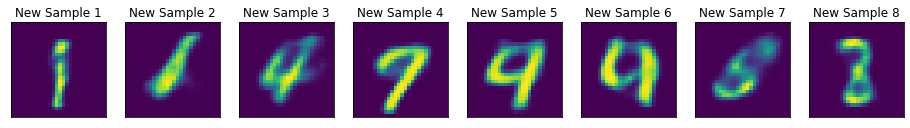

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 12], [train bce loss 10984.1183 +/- 394.1746], [train kld loss 1239.8394 +/- 21.5013], [training time 10.81]
-------------------------------------------------------------------


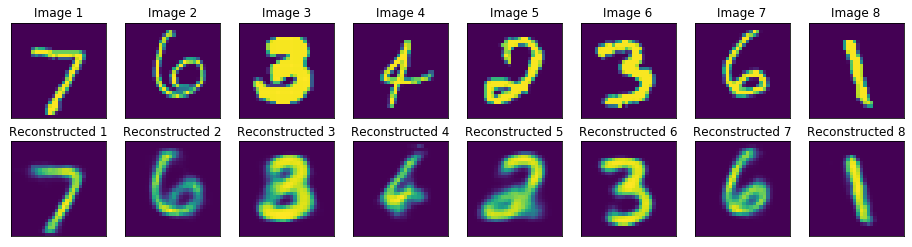

-------------------------------------------------------------------
[epoch 12], [test bce loss 10874.3649 +/- 578.4234], [test kld loss 1252.2311 +/- 47.1821], [testing time 2.31]
-------------------------------------------------------------------


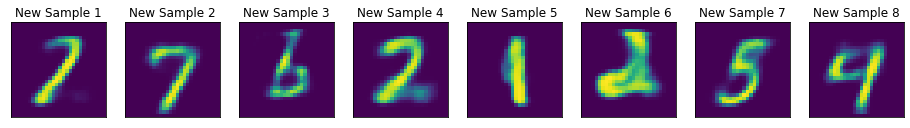

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 13], [train bce loss 10889.2438 +/- 382.0899], [train kld loss 1247.8294 +/- 22.4782], [training time 10.80]
-------------------------------------------------------------------


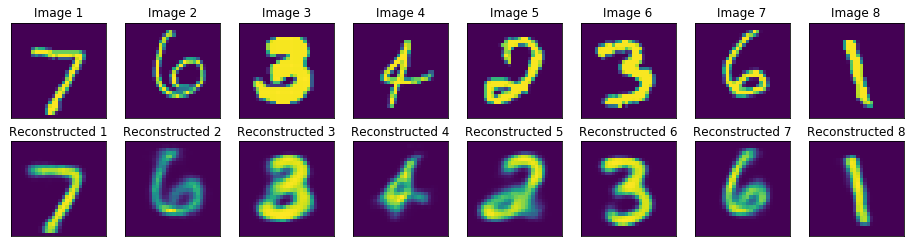

-------------------------------------------------------------------
[epoch 13], [test bce loss 10807.5993 +/- 587.9950], [test kld loss 1252.5970 +/- 50.6771], [testing time 2.16]
-------------------------------------------------------------------


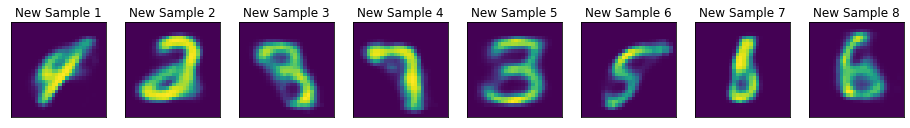

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 14], [train bce loss 10787.7164 +/- 376.3835], [train kld loss 1265.9799 +/- 24.1081], [training time 10.74]
-------------------------------------------------------------------


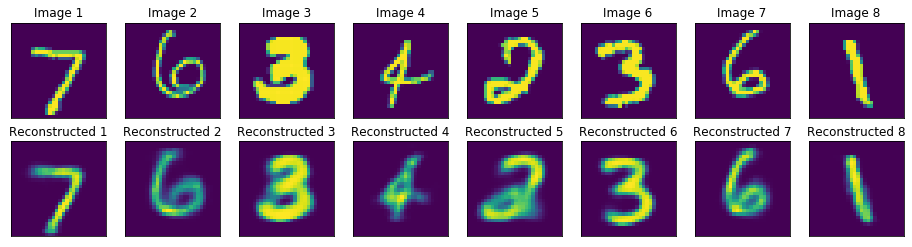

-------------------------------------------------------------------
[epoch 14], [test bce loss 10668.6098 +/- 585.7174], [test kld loss 1292.5063 +/- 50.7034], [testing time 2.35]
-------------------------------------------------------------------


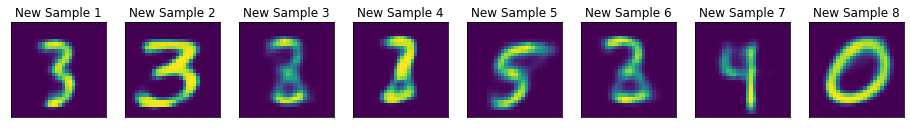

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 15], [train bce loss 10641.2205 +/- 389.5882], [train kld loss 1307.9590 +/- 25.4165], [training time 10.84]
-------------------------------------------------------------------


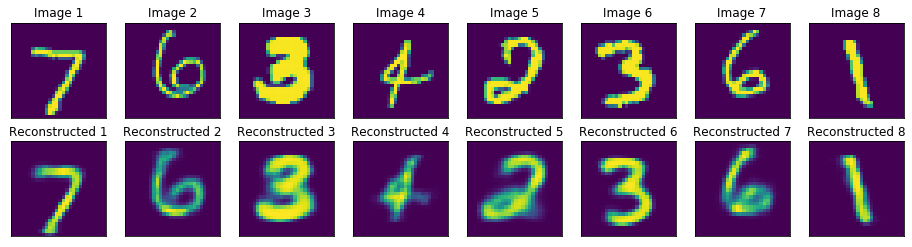

-------------------------------------------------------------------
[epoch 15], [test bce loss 10523.7352 +/- 587.0318], [test kld loss 1343.4610 +/- 52.1250], [testing time 2.12]
-------------------------------------------------------------------


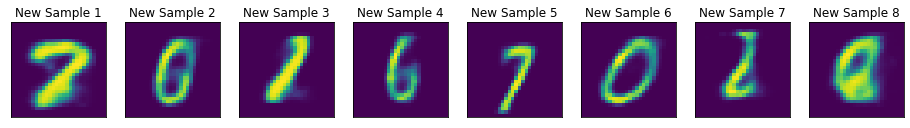

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 16], [train bce loss 10526.1804 +/- 371.9147], [train kld loss 1333.1024 +/- 24.2598], [training time 10.84]
-------------------------------------------------------------------


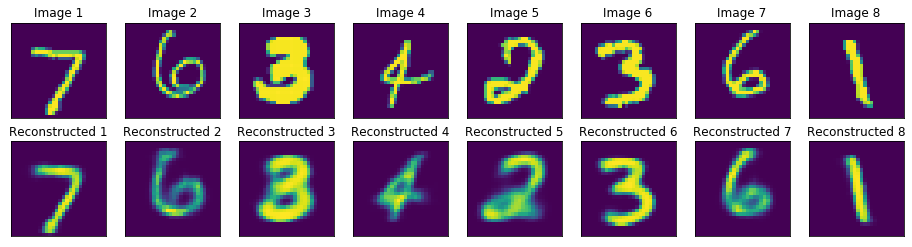

-------------------------------------------------------------------
[epoch 16], [test bce loss 10449.2661 +/- 579.4200], [test kld loss 1320.5465 +/- 49.3971], [testing time 2.32]
-------------------------------------------------------------------


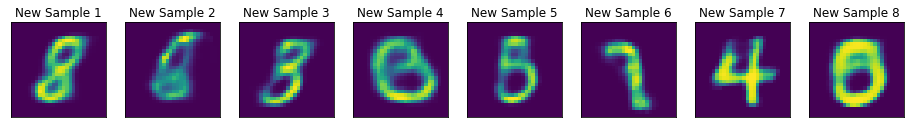

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 17], [train bce loss 10411.5489 +/- 380.2115], [train kld loss 1353.8909 +/- 24.2961], [training time 10.75]
-------------------------------------------------------------------


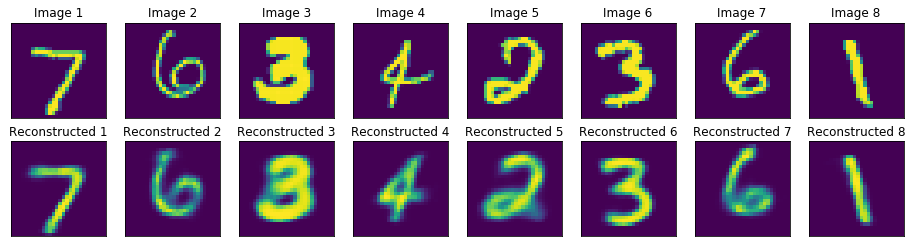

-------------------------------------------------------------------
[epoch 17], [test bce loss 10324.3438 +/- 587.3866], [test kld loss 1361.4123 +/- 51.6307], [testing time 2.14]
-------------------------------------------------------------------


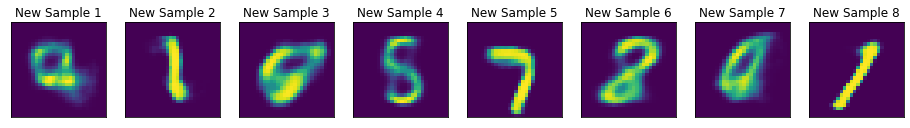

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 18], [train bce loss 10301.5867 +/- 366.7486], [train kld loss 1371.1957 +/- 22.1960], [training time 11.34]
-------------------------------------------------------------------


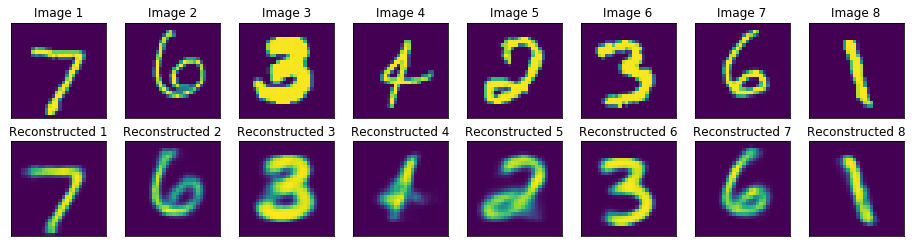

-------------------------------------------------------------------
[epoch 18], [test bce loss 10251.0453 +/- 580.5754], [test kld loss 1364.4486 +/- 46.3843], [testing time 2.26]
-------------------------------------------------------------------


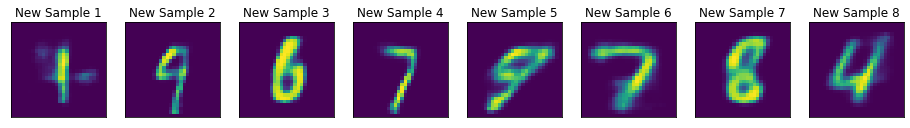

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 19], [train bce loss 10213.6316 +/- 367.1504], [train kld loss 1382.1721 +/- 23.1164], [training time 10.76]
-------------------------------------------------------------------


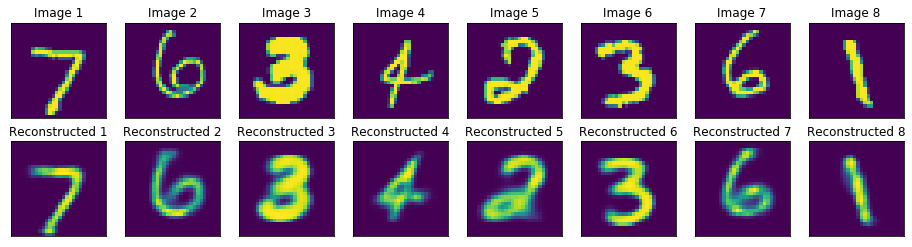

-------------------------------------------------------------------
[epoch 19], [test bce loss 10173.9094 +/- 582.9298], [test kld loss 1378.5329 +/- 45.3779], [testing time 2.13]
-------------------------------------------------------------------


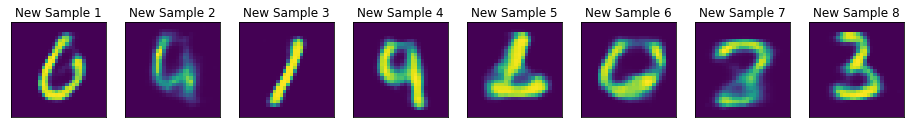

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 20], [train bce loss 10146.5846 +/- 357.5785], [train kld loss 1391.2162 +/- 24.0459], [training time 10.68]
-------------------------------------------------------------------


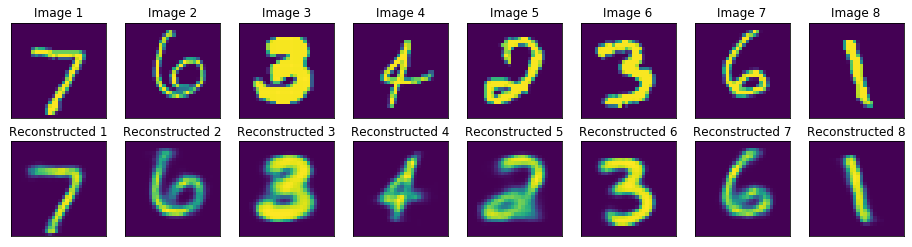

-------------------------------------------------------------------
[epoch 20], [test bce loss 10137.9914 +/- 588.9150], [test kld loss 1367.5387 +/- 44.9736], [testing time 2.16]
-------------------------------------------------------------------


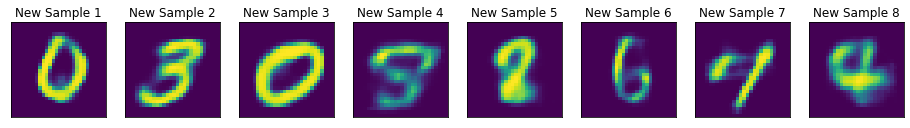

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 21], [train bce loss 10084.2060 +/- 385.1309], [train kld loss 1399.7683 +/- 23.7109], [training time 10.73]
-------------------------------------------------------------------


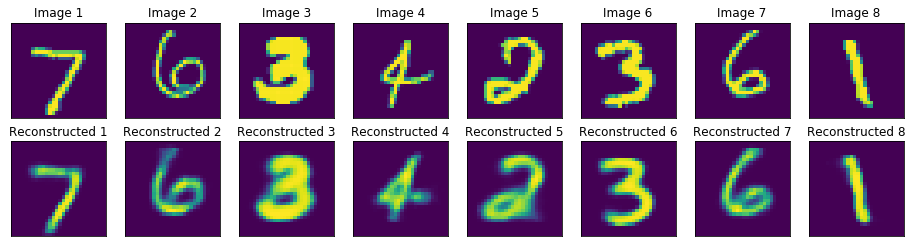

-------------------------------------------------------------------
[epoch 21], [test bce loss 10084.7703 +/- 579.7959], [test kld loss 1376.7404 +/- 46.2128], [testing time 2.16]
-------------------------------------------------------------------


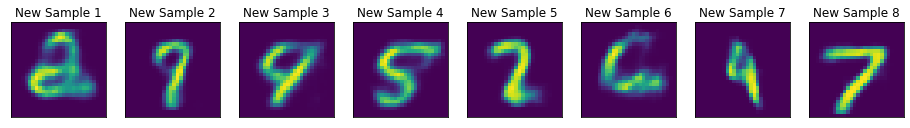

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 22], [train bce loss 10034.1952 +/- 363.1842], [train kld loss 1406.9496 +/- 23.9786], [training time 10.75]
-------------------------------------------------------------------


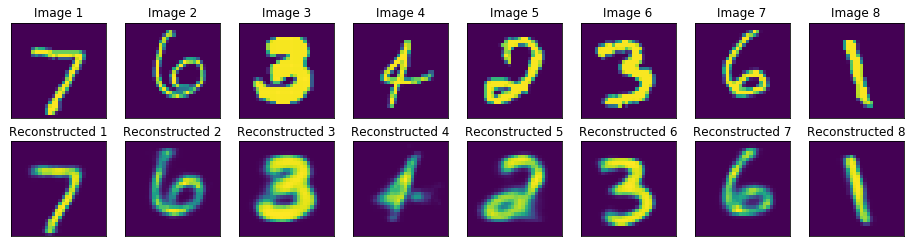

-------------------------------------------------------------------
[epoch 22], [test bce loss 9966.8464 +/- 587.5648], [test kld loss 1457.9378 +/- 49.0628], [testing time 2.12]
-------------------------------------------------------------------


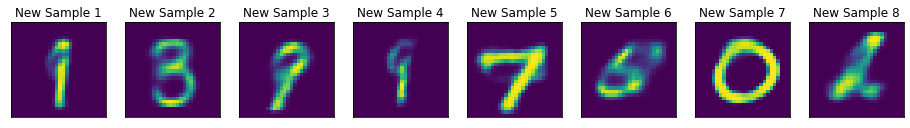

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 23], [train bce loss 9983.3687 +/- 349.3776], [train kld loss 1414.5401 +/- 23.5024], [training time 10.74]
-------------------------------------------------------------------


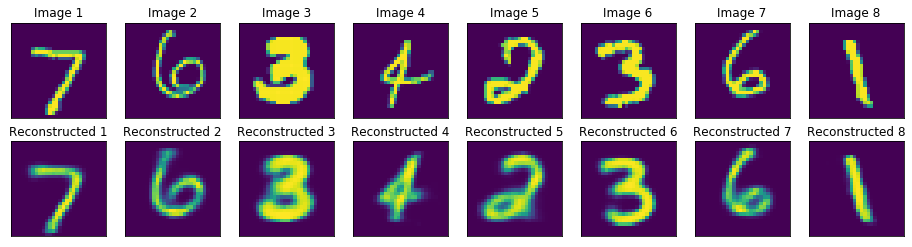

-------------------------------------------------------------------
[epoch 23], [test bce loss 9962.2148 +/- 594.5205], [test kld loss 1429.0943 +/- 45.8128], [testing time 2.35]
-------------------------------------------------------------------


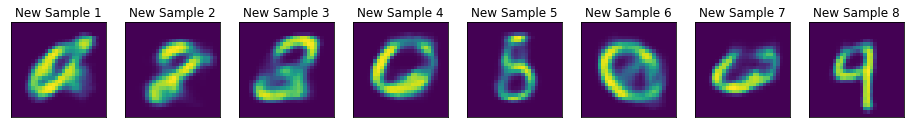

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 24], [train bce loss 9932.9618 +/- 345.9170], [train kld loss 1422.6079 +/- 24.5201], [training time 10.83]
-------------------------------------------------------------------


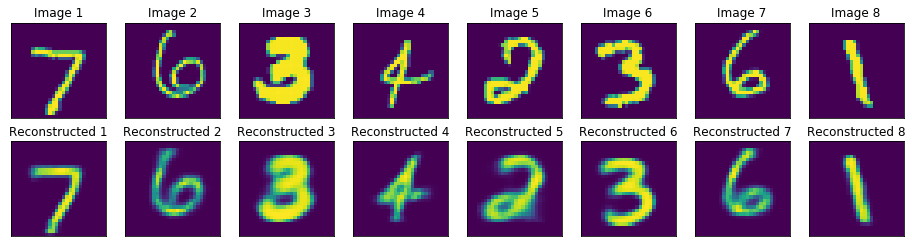

-------------------------------------------------------------------
[epoch 24], [test bce loss 9913.1893 +/- 581.9204], [test kld loss 1422.2722 +/- 49.4451], [testing time 2.16]
-------------------------------------------------------------------


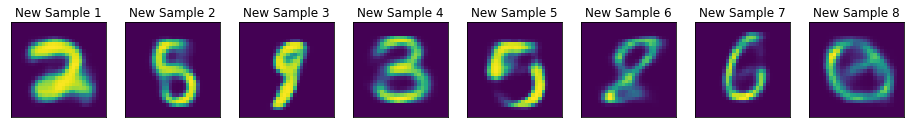

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 25], [train bce loss 9879.2366 +/- 353.9712], [train kld loss 1435.8030 +/- 25.7175], [training time 10.79]
-------------------------------------------------------------------


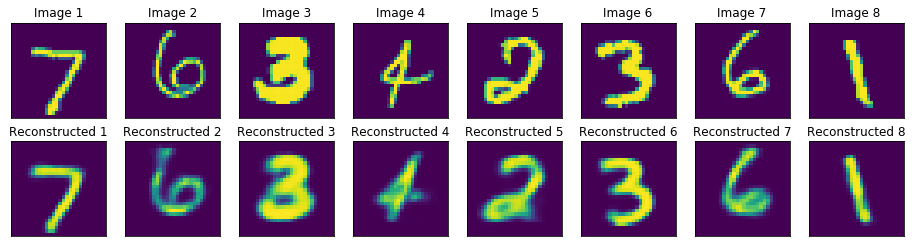

-------------------------------------------------------------------
[epoch 25], [test bce loss 9875.8251 +/- 579.8498], [test kld loss 1428.6804 +/- 51.6879], [testing time 2.36]
-------------------------------------------------------------------


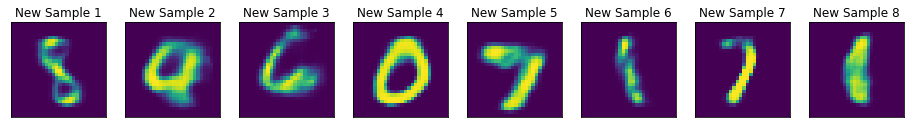

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 26], [train bce loss 9821.5034 +/- 344.8002], [train kld loss 1452.4395 +/- 22.4266], [training time 10.97]
-------------------------------------------------------------------


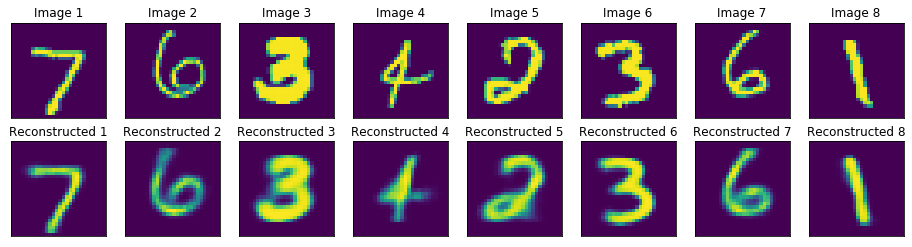

-------------------------------------------------------------------
[epoch 26], [test bce loss 9787.2432 +/- 578.9886], [test kld loss 1469.4042 +/- 48.8471], [testing time 2.17]
-------------------------------------------------------------------


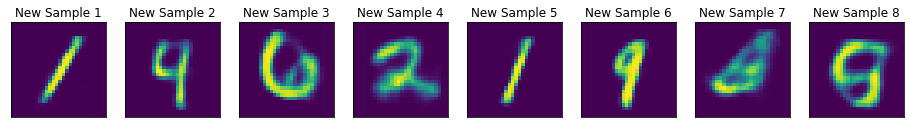

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 27], [train bce loss 9775.8301 +/- 351.0594], [train kld loss 1463.7476 +/- 26.4676], [training time 10.93]
-------------------------------------------------------------------


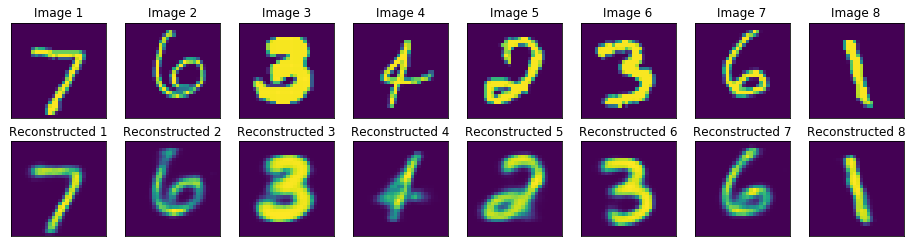

-------------------------------------------------------------------
[epoch 27], [test bce loss 9769.1866 +/- 586.5718], [test kld loss 1461.9354 +/- 53.7297], [testing time 2.35]
-------------------------------------------------------------------


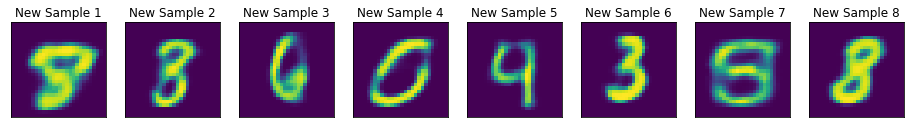

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 28], [train bce loss 9730.8314 +/- 337.5143], [train kld loss 1473.7449 +/- 24.9857], [training time 10.74]
-------------------------------------------------------------------


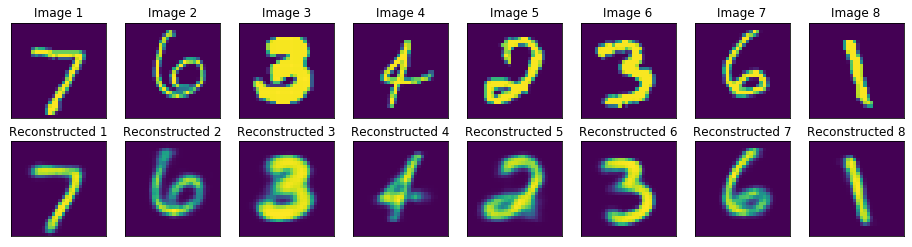

-------------------------------------------------------------------
[epoch 28], [test bce loss 9750.1919 +/- 573.0190], [test kld loss 1464.1046 +/- 50.1434], [testing time 2.17]
-------------------------------------------------------------------


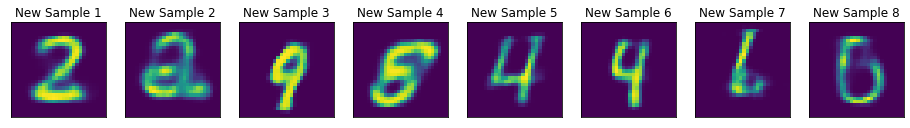

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 29], [train bce loss 9689.2365 +/- 340.8639], [train kld loss 1482.4462 +/- 24.3702], [training time 11.33]
-------------------------------------------------------------------


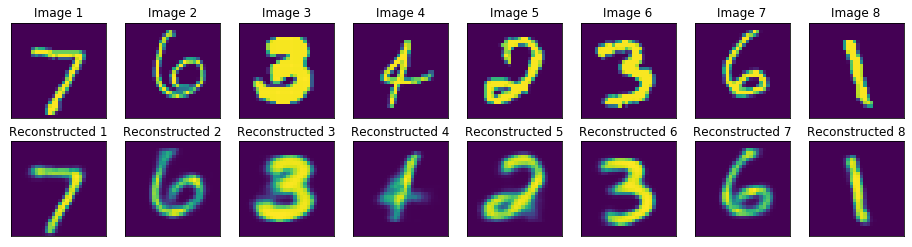

-------------------------------------------------------------------
[epoch 29], [test bce loss 9695.6378 +/- 564.3826], [test kld loss 1493.6160 +/- 51.4943], [testing time 2.74]
-------------------------------------------------------------------


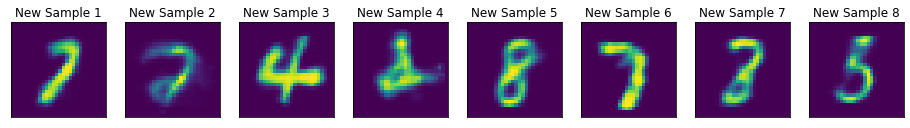

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 30], [train bce loss 9645.8858 +/- 335.0710], [train kld loss 1492.9847 +/- 23.6825], [training time 10.88]
-------------------------------------------------------------------


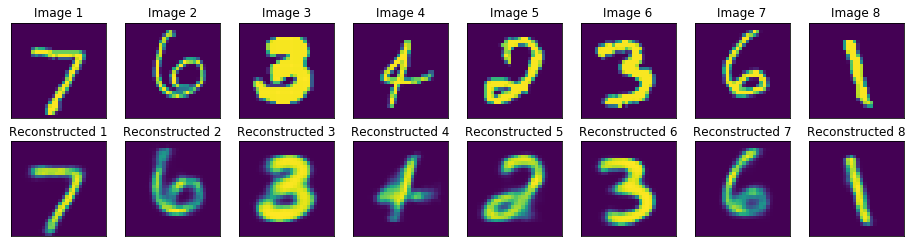

-------------------------------------------------------------------
[epoch 30], [test bce loss 9637.8300 +/- 583.1928], [test kld loss 1511.9548 +/- 49.6281], [testing time 2.19]
-------------------------------------------------------------------


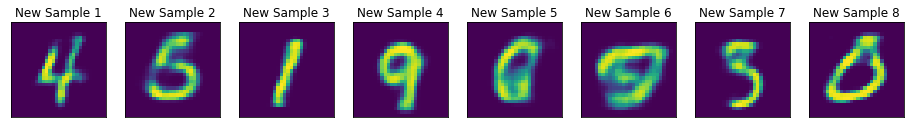

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 31], [train bce loss 9595.5501 +/- 338.1283], [train kld loss 1507.4227 +/- 26.0373], [training time 10.89]
-------------------------------------------------------------------


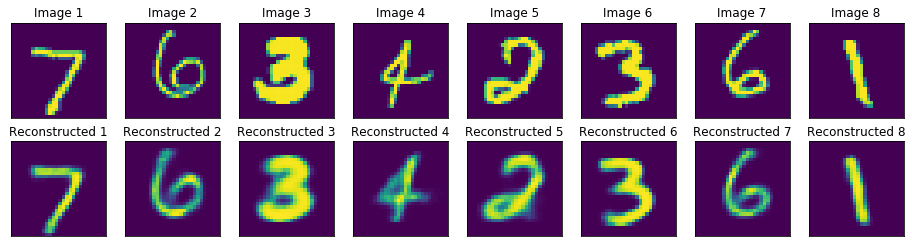

-------------------------------------------------------------------
[epoch 31], [test bce loss 9580.2907 +/- 572.4852], [test kld loss 1527.1957 +/- 52.3975], [testing time 2.16]
-------------------------------------------------------------------


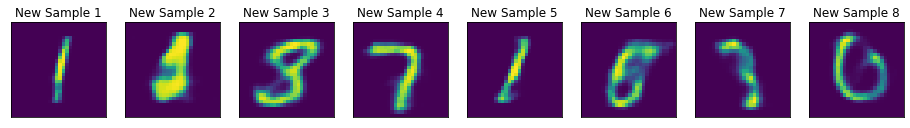

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 32], [train bce loss 9553.7831 +/- 342.7059], [train kld loss 1511.5477 +/- 24.8244], [training time 10.78]
-------------------------------------------------------------------


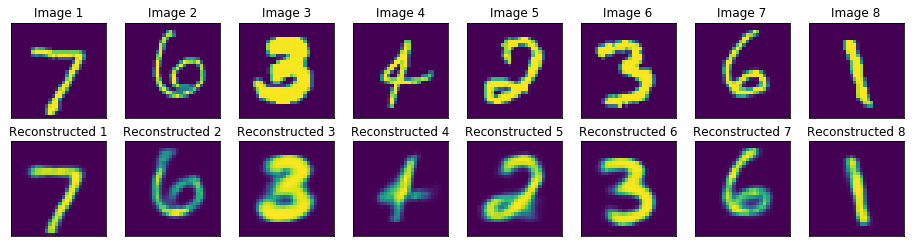

-------------------------------------------------------------------
[epoch 32], [test bce loss 9561.1872 +/- 577.6130], [test kld loss 1512.8082 +/- 52.8007], [testing time 2.13]
-------------------------------------------------------------------


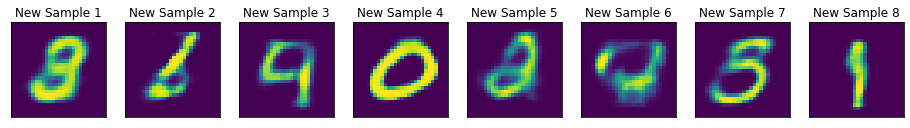

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 33], [train bce loss 9517.9110 +/- 334.9321], [train kld loss 1518.1928 +/- 26.2242], [training time 10.84]
-------------------------------------------------------------------


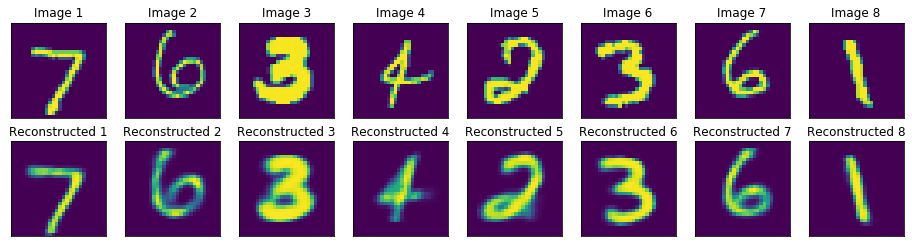

-------------------------------------------------------------------
[epoch 33], [test bce loss 9525.5018 +/- 571.6867], [test kld loss 1539.5683 +/- 51.0041], [testing time 2.18]
-------------------------------------------------------------------


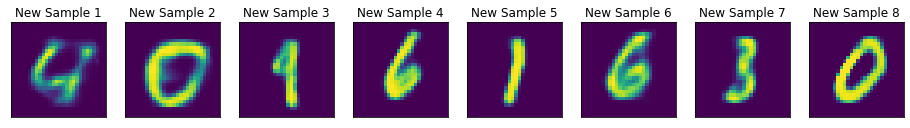

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 34], [train bce loss 9485.0945 +/- 343.2550], [train kld loss 1527.6258 +/- 25.2781], [training time 10.84]
-------------------------------------------------------------------


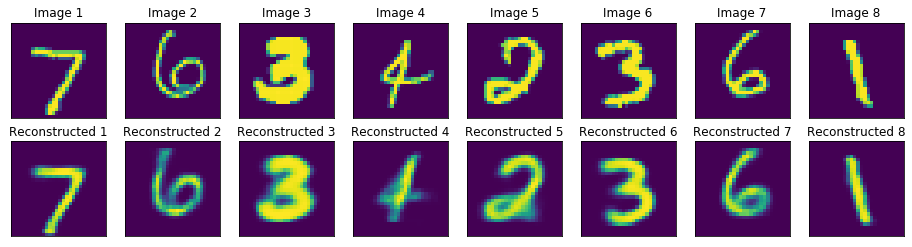

-------------------------------------------------------------------
[epoch 34], [test bce loss 9508.3078 +/- 573.7020], [test kld loss 1528.3506 +/- 51.5832], [testing time 2.38]
-------------------------------------------------------------------


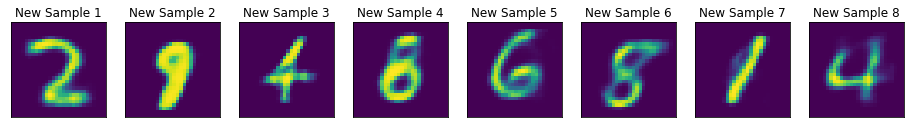

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 35], [train bce loss 9452.4571 +/- 343.0757], [train kld loss 1531.8079 +/- 25.1723], [training time 10.85]
-------------------------------------------------------------------


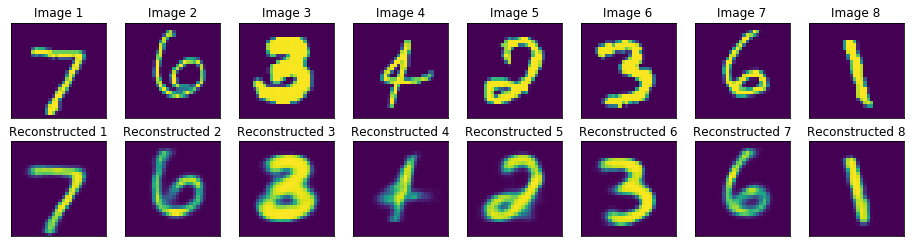

-------------------------------------------------------------------
[epoch 35], [test bce loss 9464.0981 +/- 581.0778], [test kld loss 1557.8796 +/- 51.7272], [testing time 2.19]
-------------------------------------------------------------------


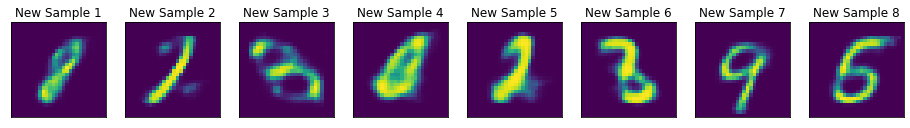

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 36], [train bce loss 9426.3940 +/- 332.4646], [train kld loss 1537.8676 +/- 25.9122], [training time 10.87]
-------------------------------------------------------------------


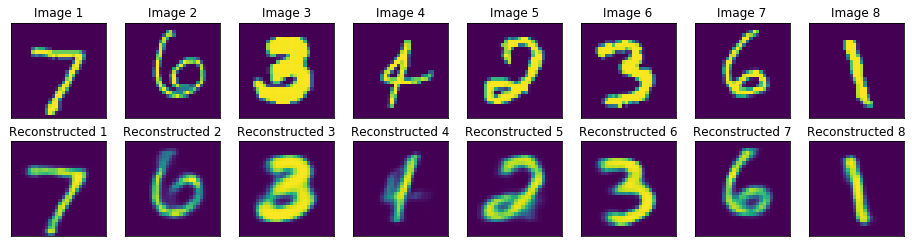

-------------------------------------------------------------------
[epoch 36], [test bce loss 9442.9589 +/- 574.0845], [test kld loss 1558.7776 +/- 48.2942], [testing time 2.30]
-------------------------------------------------------------------


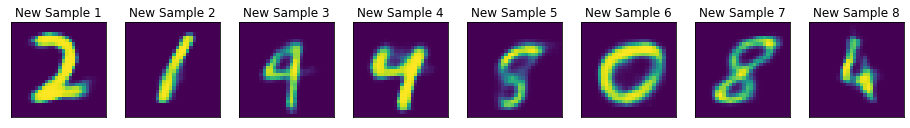

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 37], [train bce loss 9397.2277 +/- 337.6486], [train kld loss 1541.6404 +/- 24.2100], [training time 10.74]
-------------------------------------------------------------------


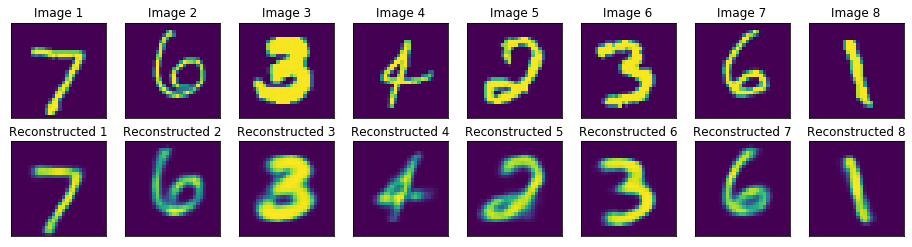

-------------------------------------------------------------------
[epoch 37], [test bce loss 9445.3878 +/- 577.3947], [test kld loss 1542.0740 +/- 49.7915], [testing time 2.15]
-------------------------------------------------------------------


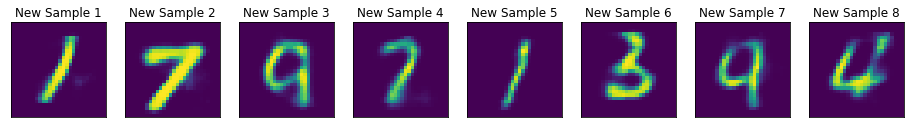

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 38], [train bce loss 9374.5142 +/- 332.5795], [train kld loss 1547.7458 +/- 25.0116], [training time 10.79]
-------------------------------------------------------------------


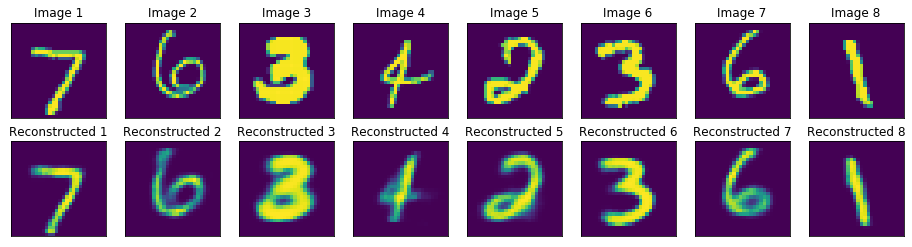

-------------------------------------------------------------------
[epoch 38], [test bce loss 9439.8441 +/- 565.6457], [test kld loss 1531.7586 +/- 49.2374], [testing time 2.29]
-------------------------------------------------------------------


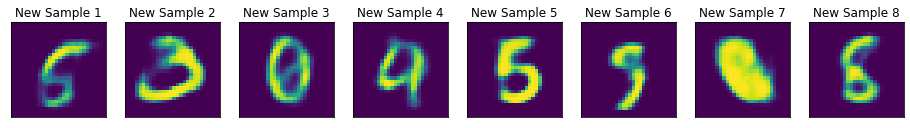

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 39], [train bce loss 9349.4224 +/- 331.2205], [train kld loss 1551.8871 +/- 25.0429], [training time 10.99]
-------------------------------------------------------------------


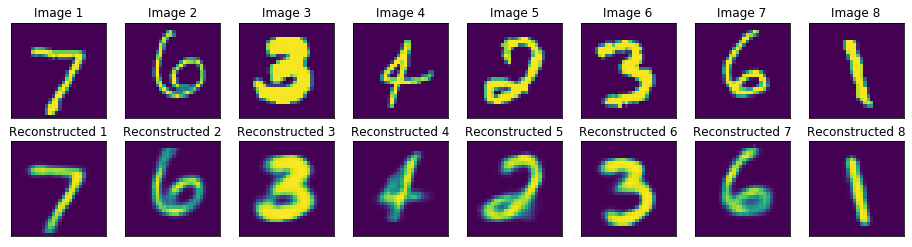

-------------------------------------------------------------------
[epoch 39], [test bce loss 9374.7449 +/- 577.0044], [test kld loss 1572.7669 +/- 50.5459], [testing time 2.13]
-------------------------------------------------------------------


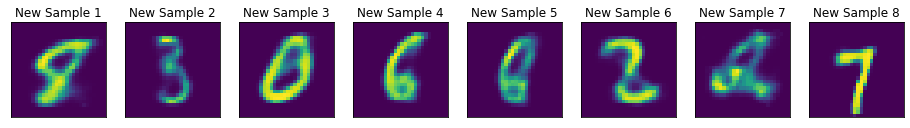

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 40], [train bce loss 9325.9352 +/- 331.6856], [train kld loss 1555.2091 +/- 23.7643], [training time 11.46]
-------------------------------------------------------------------


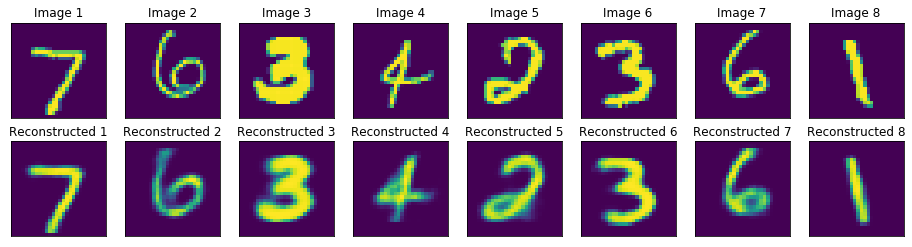

-------------------------------------------------------------------
[epoch 40], [test bce loss 9383.7354 +/- 572.3883], [test kld loss 1559.5285 +/- 52.4700], [testing time 2.63]
-------------------------------------------------------------------


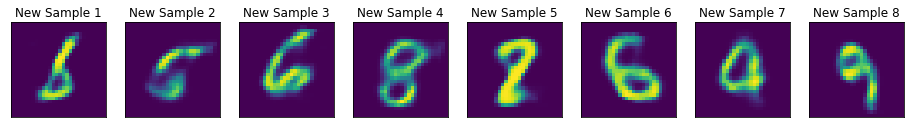

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 41], [train bce loss 9302.2112 +/- 331.4008], [train kld loss 1561.6940 +/- 24.8090], [training time 10.69]
-------------------------------------------------------------------


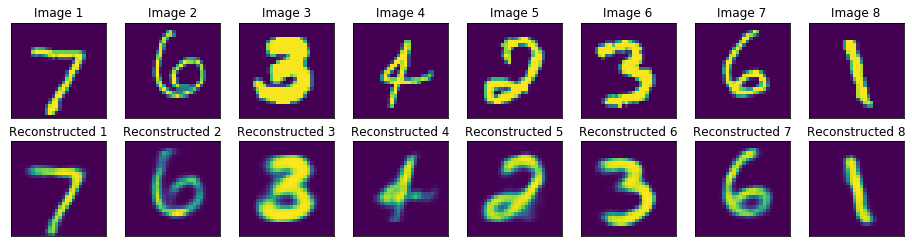

-------------------------------------------------------------------
[epoch 41], [test bce loss 9375.8435 +/- 568.2535], [test kld loss 1554.0971 +/- 48.8155], [testing time 2.15]
-------------------------------------------------------------------


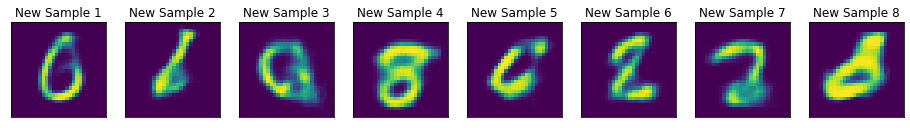

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 42], [train bce loss 9276.9767 +/- 318.8814], [train kld loss 1569.8143 +/- 27.8114], [training time 10.82]
-------------------------------------------------------------------


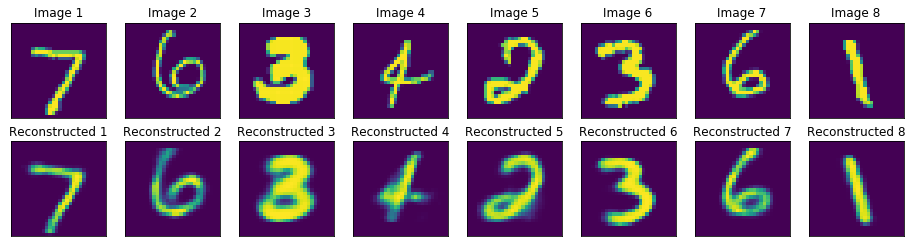

-------------------------------------------------------------------
[epoch 42], [test bce loss 9304.5486 +/- 574.3902], [test kld loss 1596.8298 +/- 54.1029], [testing time 2.16]
-------------------------------------------------------------------


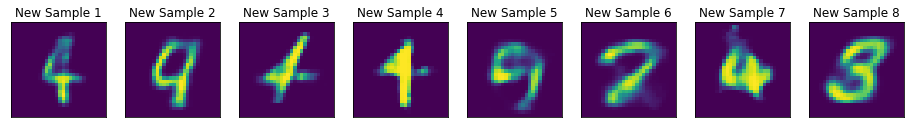

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 43], [train bce loss 9247.8433 +/- 316.2096], [train kld loss 1580.0685 +/- 25.6561], [training time 10.84]
-------------------------------------------------------------------


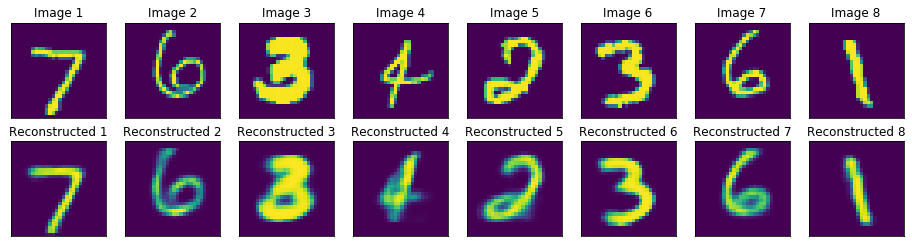

-------------------------------------------------------------------
[epoch 43], [test bce loss 9345.1466 +/- 573.8728], [test kld loss 1550.5701 +/- 50.0097], [testing time 2.17]
-------------------------------------------------------------------


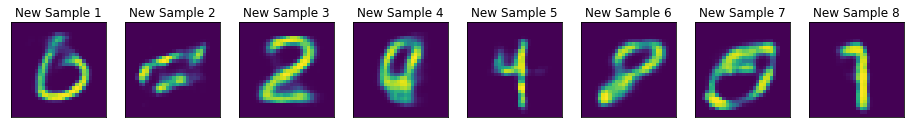

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 44], [train bce loss 9214.6678 +/- 318.1909], [train kld loss 1589.1156 +/- 25.1178], [training time 10.77]
-------------------------------------------------------------------


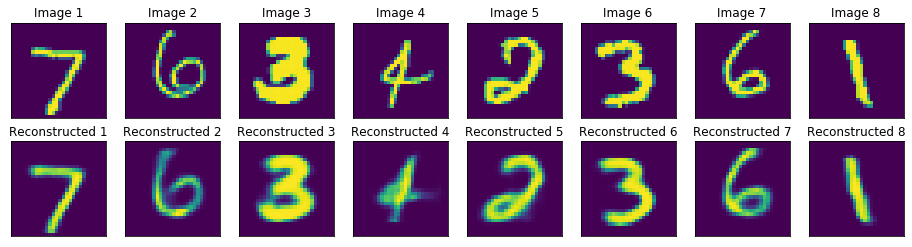

-------------------------------------------------------------------
[epoch 44], [test bce loss 9290.6882 +/- 580.2566], [test kld loss 1581.8600 +/- 50.9478], [testing time 2.15]
-------------------------------------------------------------------


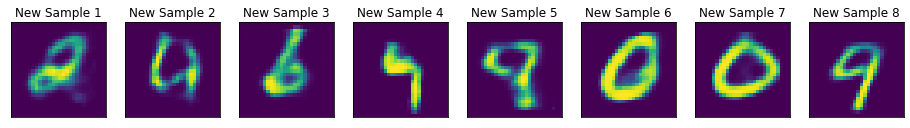

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 45], [train bce loss 9185.4148 +/- 310.4337], [train kld loss 1597.9526 +/- 27.6075], [training time 10.87]
-------------------------------------------------------------------


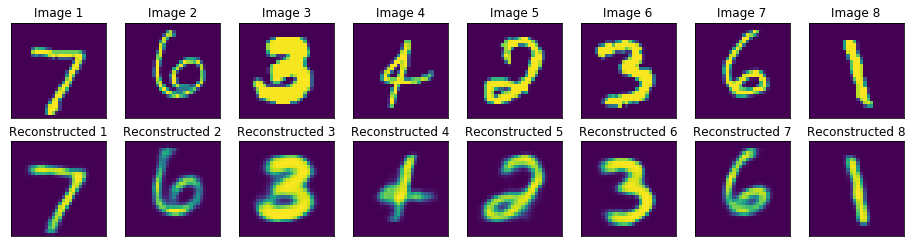

-------------------------------------------------------------------
[epoch 45], [test bce loss 9246.8628 +/- 568.1041], [test kld loss 1615.8475 +/- 54.7751], [testing time 2.32]
-------------------------------------------------------------------


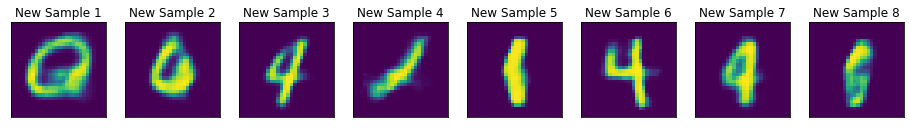

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 46], [train bce loss 9155.8856 +/- 332.0457], [train kld loss 1607.5600 +/- 28.3204], [training time 10.81]
-------------------------------------------------------------------


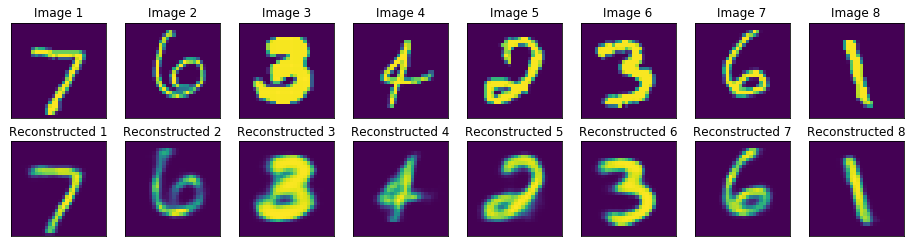

-------------------------------------------------------------------
[epoch 46], [test bce loss 9223.4720 +/- 565.4147], [test kld loss 1608.7019 +/- 49.9555], [testing time 2.16]
-------------------------------------------------------------------


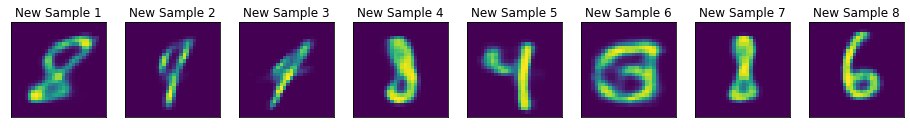

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 47], [train bce loss 9124.7601 +/- 316.4495], [train kld loss 1616.3770 +/- 27.2999], [training time 10.75]
-------------------------------------------------------------------


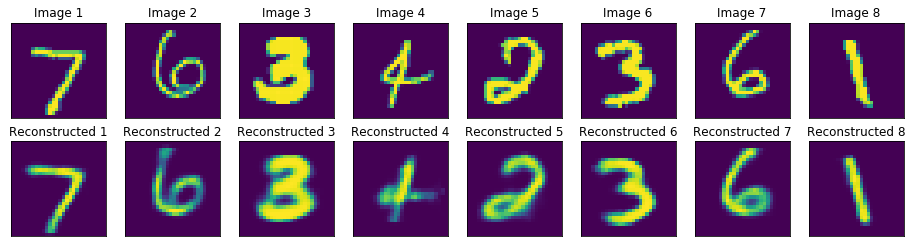

-------------------------------------------------------------------
[epoch 47], [test bce loss 9210.7861 +/- 573.5068], [test kld loss 1616.2518 +/- 49.7223], [testing time 2.31]
-------------------------------------------------------------------


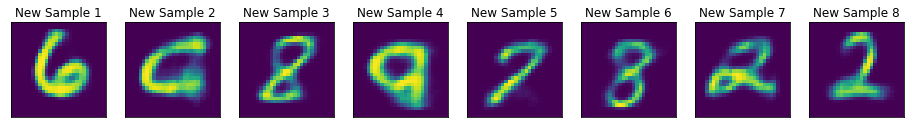

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 48], [train bce loss 9092.0781 +/- 305.8421], [train kld loss 1626.0413 +/- 29.4046], [training time 10.86]
-------------------------------------------------------------------


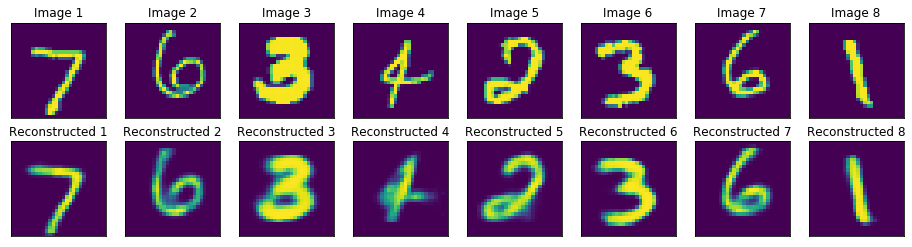

-------------------------------------------------------------------
[epoch 48], [test bce loss 9183.0114 +/- 572.1759], [test kld loss 1616.8321 +/- 53.2058], [testing time 2.18]
-------------------------------------------------------------------


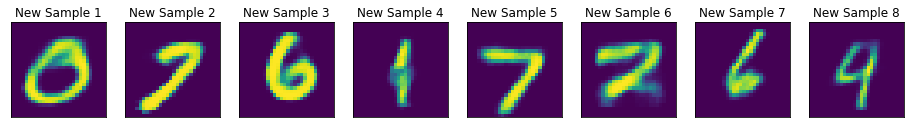

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 49], [train bce loss 9056.6025 +/- 305.6731], [train kld loss 1635.4402 +/- 29.9339], [training time 10.73]
-------------------------------------------------------------------


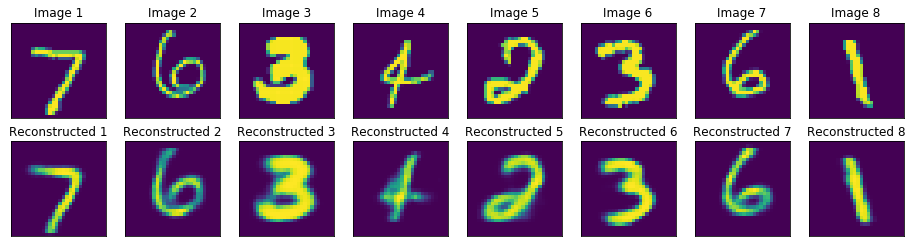

-------------------------------------------------------------------
[epoch 49], [test bce loss 9127.3859 +/- 572.3938], [test kld loss 1660.1669 +/- 52.3004], [testing time 2.36]
-------------------------------------------------------------------


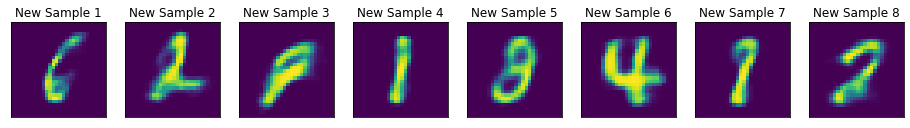

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 50], [train bce loss 9025.7873 +/- 306.2913], [train kld loss 1642.3183 +/- 27.5163], [training time 10.71]
-------------------------------------------------------------------


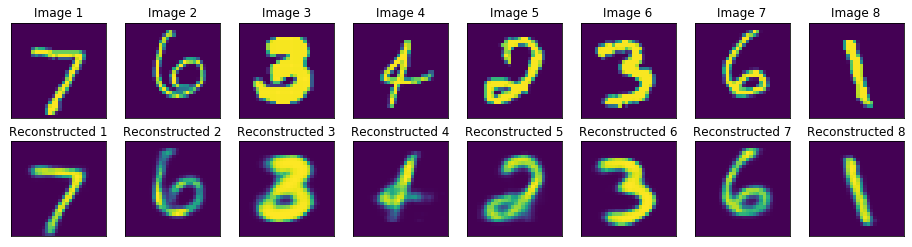

-------------------------------------------------------------------
[epoch 50], [test bce loss 9118.2062 +/- 571.5107], [test kld loss 1633.7803 +/- 52.2641], [testing time 2.17]
-------------------------------------------------------------------


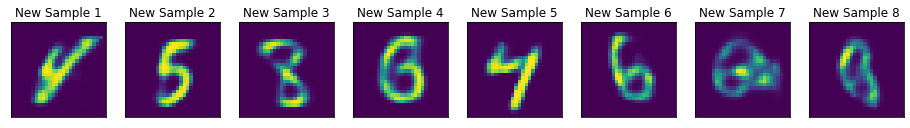

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------


In [ ]:
# Iterating over epochs.
for epoch in range(1, args['epoch_num'] + 1):

    # Training function.
    train(train_loader, net, optimizer, epoch)

    # Computing test loss and metrics.
    test(test_loader, net, epoch)
    
    # Evaluating sample generation in VAE.
    evaluate(net, args['num_samples'], args['num_gauss'])
    
    print('-- End of Epoch ---------------------------------------------------')
    print('-------------------------------------------------------------------')

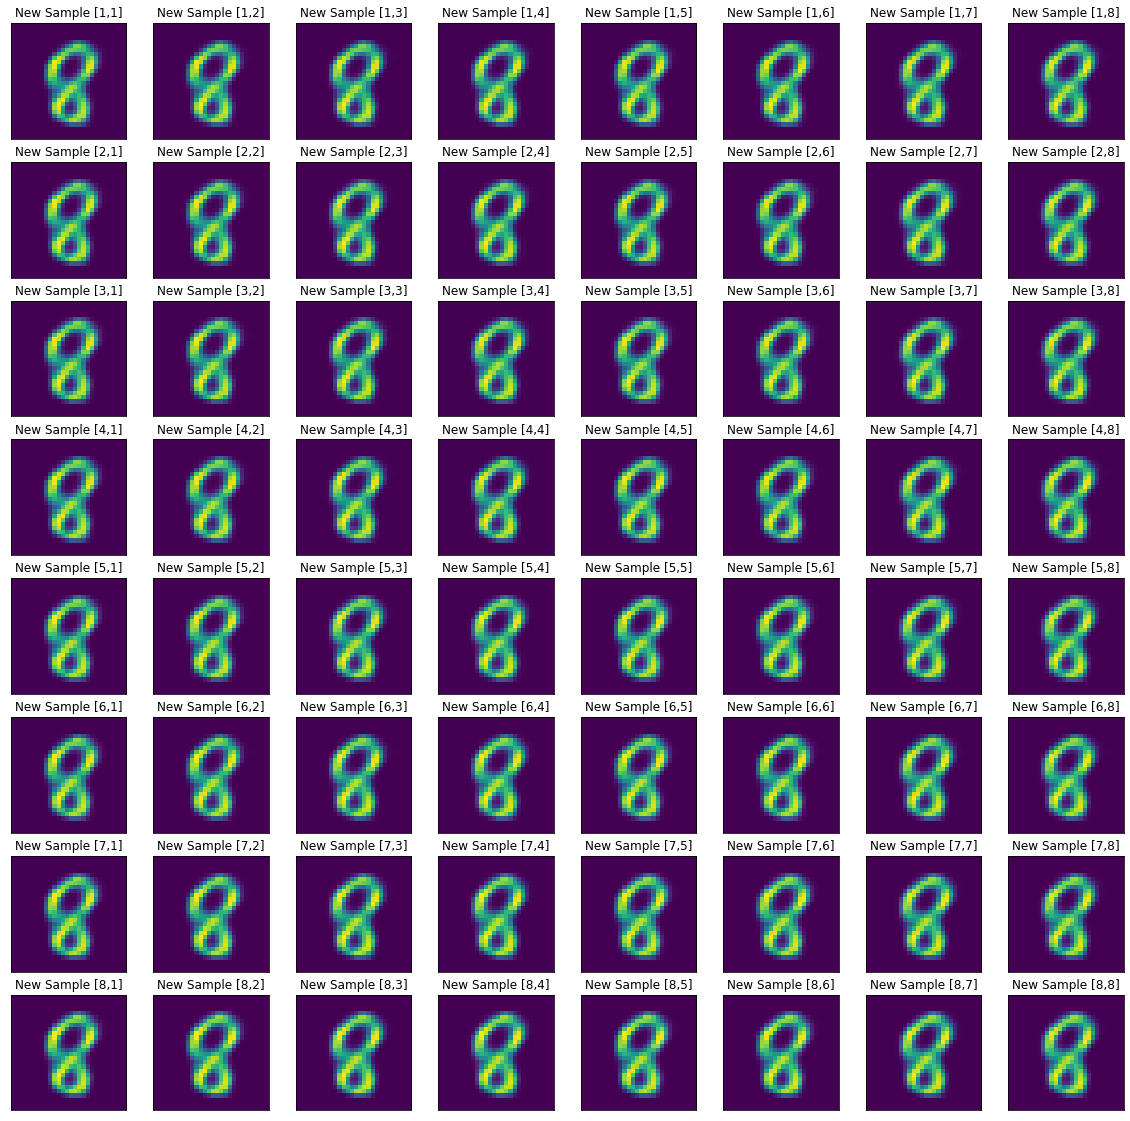

In [ ]:
# Evaluation procedure for sample generation.
def generate_2d(net, n_samples, n_gauss):

    # Setting network for evaluation mode.
    net.eval()
    
    # Creating linear space to visualize bivariate gaussian.
    linspace_gauss = torch.linspace(-2.5, 2.5, n_samples)
    
    # Select Gaussian dimensions
    dim_linspace = (0, 1)
    
    # Plotting.
    fig, ax = plt.subplots(n_samples, n_samples, figsize=(20, 20))

    for i in range(n_samples):
        
        for j in range(n_samples):

            # Filling batch with size 1 and n_gauss zeros of dimension.
            sample = torch.zeros(1, n_gauss).to(args['device'])
            
            # Replacing zeros in dimensions dim_linspace with values from
            # variable linspace_gauss.
            sample[0, dim_linspace[0]] = linspace_gauss[j]
            sample[0, dim_linspace[1]] = linspace_gauss[i]

            # Forwarding through decoder.
            sample = net.decode(sample).detach().cpu().view(28, 28).numpy()

            # Printing sample.
            ax[j, i].imshow(sample)
            ax[j, i].set_yticks([])
            ax[j, i].set_xticks([])
            ax[j, i].set_title('New Sample [' + str(j + 1) + ',' + str(i + 1) + ']')
        
    plt.show()
    
    
generate_2d(net, args['num_samples'], args['num_gauss'])